In [1]:
import nltk
import pymorphy2
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import FreqDist
import re
import collections
import matplotlib.pyplot as plt
import os
from math import log10

In [2]:
input_text = 'story.txt'
output_pymorphy = 'output_pymorphy.txt'
output_stemmer = 'output_stemmer.txt'
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language="russian")
lemma_list = []
stemma_list = []

In [3]:
# 1. Лемматизация
with open(input_text, 'r', encoding='windows-1251') as infile:
    text = infile.read()
    tokens = nltk.word_tokenize(text)
    # Регулярное выражение, чтобы убрать числа
    tokens = [i for i in tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
    lemma_list = [morph.parse(i)[0].normal_form for i in tokens]
    unordered_dict = collections.Counter([i for i in lemma_list]).items()
    ordered_list = sorted(unordered_dict, key=lambda i: i[1], reverse=True)

    with open(output_pymorphy, 'w') as outfile:
        for i in ordered_list:
            outfile.write(i[0] + ' ' + str(i[1]) + '\n')

In [4]:
# 2. Стемминг
with open(input_text, 'r', encoding='windows-1251') as infile:
    text = infile.read()
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
    stemma_list = [snowball.stem(i) for i in tokens]
    unordered_dict = collections.Counter([snowball.stem(i) for i in stemma_list]).items()
    ordered_list = sorted(unordered_dict, key=lambda i: i[1], reverse=True)
    with open(output_stemmer, 'w') as outfile:
        for i in ordered_list:
            outfile.write(i[0] + ' ' + str(i[1]) + '\n')

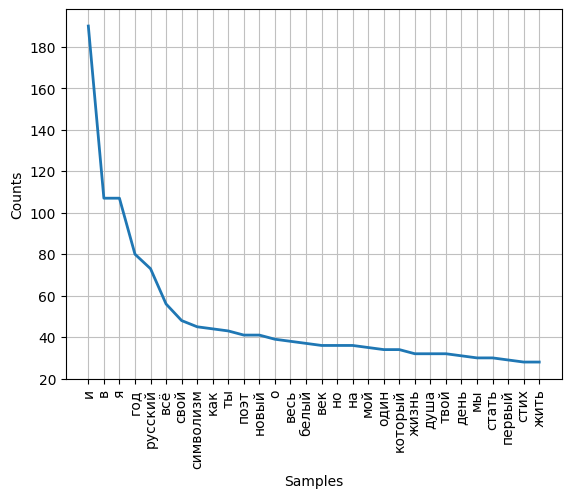

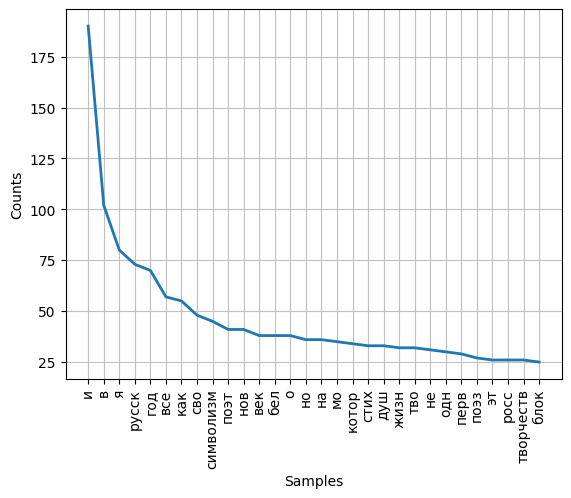

In [5]:
# 2.1. Сравнение словарей
plt.ion()
lemma_dist = FreqDist(lemma_list)
lemma_dist.plot(30, cumulative=False)
stemma_dict = FreqDist(stemma_list)
stemma_dict.plot(30, cumulative=False)
plt.ioff()
plt.show()

In [6]:
# 3 TF-IDF. Выбранная тема - Неизвестные стихотворения 1922-1935 годов
directory = 'unknown_poems'

# Основной документ
main_poem = 'unknown_poems\\Аквариум.txt'

# Число документов в коллекции
doc_count = len(os.listdir(directory))
# 3.1 Лемматизация

# Лемматизация
# Корпус документов
corpus = {}
# Используем словарь всех файлов, где значение по ключу(название файла) есть список слов по частотам
# Цикл по всем файлам
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)

    with open(file, 'r', encoding="utf8") as infile:
        text = infile.read()
        tokens = nltk.word_tokenize(text)
        tokens = [i for i in tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
        lemma_list = [morph.parse(i)[0].normal_form for i in tokens]
        unordered_dict = collections.Counter([i for i in lemma_list]).items()
        ordered_list = sorted(unordered_dict, key=lambda i: i[1], reverse=True)

        # Добавление документа в корпус
        corpus[file] = []

        # Число слов в документе
        word_count = len(tokens)

        for word, freq in ordered_list:
            # Очередное слово текущего документа
            new_word = {'value': word, 'tf': freq/word_count}
            corpus[file].append(new_word)

# Корпус основного документа
main_corpus = corpus['unknown_poems\\Аквариум.txt']

# TF - частота встречаемости конкретного слова в данном документе (число_вхождений_слова/все_слова)
# IDF - log(число_документов/число_документов_со_словом)
# TF-IDF = TF * IDF

for i, word in enumerate(main_corpus):
    Count = 0
    for doc in corpus:
        for docword in corpus[doc]:
                if docword['value'] == word['value']:
                    Count += 1
                    break
    main_corpus[i]['idf'] = log10(doc_count/Count)
    main_corpus[i]['tf-idf'] =  main_corpus[i]['tf'] * main_corpus[i]['idf']
main_corpus = sorted(main_corpus, key=lambda x: x['tf-idf'], reverse=True)

# Вывод
print('Filename: ' + main_poem + ' (Лемматизация)')
print(("{: >20}|{: >20}|{: >20}|{: >20}|{: >20}").format('Номер', 'Лемма', 'TF', 'IDF', 'TF-IDF'))
for i, word in enumerate(main_corpus):
    print(("{: >20}|{: >20}|{: >20}|{: >20}|{: >20}").format(i, main_corpus[i]['value'], main_corpus[i]['tf'], main_corpus[i]['idf'], main_corpus[i]['tf-idf']))
    if (i == 40): break

Filename: unknown_poems\Аквариум.txt (Лемматизация)
               Номер|               Лемма|                  TF|                 IDF|              TF-IDF
                   0|              играть|0.023529411764705882|  0.8239087409443188|0.019386088022219264
                   1|                 так|0.023529411764705882|  0.6989700043360189|0.016446353043200444
                   2|                 вот|0.023529411764705882|  0.6989700043360189|0.016446353043200444
                   3|               марка|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   4|               мария|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   5|               талов|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   6|         нейтральный|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   7|           подводный|0.011764705882352941|  1.3010299956639813|0.015306235243105662
   

In [7]:
# Стеммизация
# Корпус документов
corpus = {}
# Используем словарь всех файлов, где значение по ключу(название файла) есть список слов по частотам
# Цикл по всем файлам
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)

    with open(file, 'r', encoding="utf8") as infile:
        text = infile.read()
        tokens = nltk.word_tokenize(text)
        tokens = [i for i in tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
        stemma_list = [snowball.stem(i) for i in tokens]
        unordered_dict = collections.Counter([snowball.stem(i) for i in stemma_list]).items()
        ordered_list = sorted(unordered_dict, key=lambda i: i[1], reverse=True)

        # Добавление документа в корпус
        corpus[file] = []

        # Число слов в документе
        word_count = len(tokens)

        for word, freq in ordered_list:
            # Очередное слово текущего документа
            new_word = {'value': word, 'tf': freq/word_count}
            corpus[file].append(new_word)

# Корпус основного документа
main_corpus = corpus['unknown_poems\\Аквариум.txt']

# TF - частота встречаемости конкретного слова в данном документе (число_вхождений_слова/все_слова)
# IDF - log(число_документов/число_документов_со_словом)
# TF-IDF = TF * IDF

for i, word in enumerate(main_corpus):
    Count = 0
    for doc in corpus:
        for docword in corpus[doc]:
                if docword['value'] == word['value']:
                    Count += 1
                    break
    main_corpus[i]['idf'] = log10(doc_count/Count)
    main_corpus[i]['tf-idf'] =  main_corpus[i]['tf'] * main_corpus[i]['idf']
main_corpus = sorted(main_corpus, key=lambda x: x['tf-idf'], reverse=True)

# Вывод
print('Filename: ' + main_poem + ' (Стеммизация)')
print(("{: >20}|{: >20}|{: >20}|{: >20}|{: >20}").format('Номер', 'Лемма', 'TF', 'IDF', 'TF-IDF'))
for i, word in enumerate(main_corpus):
    print(("{: >20}|{: >20}|{: >20}|{: >20}|{: >20}").format(i, main_corpus[i]['value'], main_corpus[i]['tf'], main_corpus[i]['idf'], main_corpus[i]['tf-idf']))
    if (i == 40): break

Filename: unknown_poems\Аквариум.txt (Стеммизация)
               Номер|               Лемма|                  TF|                 IDF|              TF-IDF
                   0|                 так|0.023529411764705882|  0.6989700043360189|0.016446353043200444
                   1|                 вот|0.023529411764705882|  0.6989700043360189|0.016446353043200444
                   2|                 игр|0.023529411764705882|  0.6989700043360189|0.016446353043200444
                   3|                марк|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   4|                 мар|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   5|           нейтральн|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   6|             подводн|0.011764705882352941|  1.3010299956639813|0.015306235243105662
                   7|                отек|0.011764705882352941|  1.3010299956639813|0.015306235243105662
    

In [8]:
# 4. Квазиреферирование

# Коэффициент сжатия
comp = 0.01

# Входной текст
input_text = 'story.txt'

with open(input_text, 'r', encoding='windows-1251') as infile:
    text = infile.read()

    # Убрать скрытые симолв
    text = re.sub('[\t\r\n\xa0]', ' ', text)
    text = ' '.join(text.split())

    # Предложения
    sentences = nltk.sent_tokenize(text)

    # Слова
    tokens = nltk.word_tokenize(text)
    # Регулярное выражение, чтобы убрать числа
    tokens = [i for i in tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
    lemma_list = [morph.parse(i)[0].normal_form for i in tokens]
    unordered_lemma_dict = collections.Counter([i for i in lemma_list]).items()

    # Число слов в тексте:
    lemma_count = len(tokens)

    # Слово - TF
    lemma_TF = {}
    for word, freq in unordered_lemma_dict:
        lemma_TF[word] = freq/lemma_count

    # Предложение - TF
    sentence_TF = {}
    for sentence in sentences:
        sentence_tokens = nltk.word_tokenize(sentence)
        sentence_tokens = [i for i in sentence_tokens if (i not in stop_words and bool(re.fullmatch(r"[а-яА-ЯёЁ]+", i)))]
        sentence_lemma_list = [morph.parse(i)[0].normal_form for i in sentence_tokens]
        weight = 0
        for lemma in sentence_lemma_list:
            weight += lemma_TF[lemma]
        sentence_TF[sentence] = weight

    # Сортировка предложений по весу
    sentence_TF = dict(sorted(sentence_TF.items(), key=lambda x: x[1], reverse=True))

    # Отфильровать по коэффициенту сжатия
    list_sentence_TF = list(sentence_TF)
    filter_sentences = list_sentence_TF[0: int(len(list_sentence_TF) * comp)]

    # Текст реферата в порядке изначального текста
    for sentence in sentences:
        if sentence in filter_sentences:
            print(sentence, end=' ')

Один из теоретиков символизма, Константин Бальмонт, разрабатывавший в своем творчестве медиумические, «стихийные» аспекты и искавший соответствующие новаторские средства выражения, в статье «Элементарные слова о символической поэзии» (1900) так формулирует ее главные отличительные черты: «Она говорит своим особым языком, и этот язык богат интонациями; подобно музыке и живописи, она возбуждает в душе сложное настроение, – более чем другой род поэзии, трогает наши слуховые и зрительные впечатления, заставляет читателя пройти обратный путь творчества: поэт, создавая свое символическое произведение, от абстрактного идет к конкретному, от идеи к образу, – тот, кто знакомится с его произведениями, восходит от картины к душе ее, от непосредственных образов, прекрасных в своем самостоятельном существовании, к скрытой в них духовной идеальности, придающей им двойную силу». И порой в безжизненном молчаньи, Как из гроба, веет с высоты Мне в лицо холодное дыханье Безграничной, мертвой пустоты… 26 